# Modulação Digital em Banda Passante – M-PSK

Aluno:
  * João Mário C. I. Lago

---

# Installs & Imports

In [ ]:
%pip install -q numpy matplotlib scipy

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import upfirdn

# Utils

In [72]:
def simulate_mpsk(
    M=4,
    Eb=45e-6,
    N0=1e-6,
    EbN0_dB=None,
    num_symbols=20000,
    phase_offset=np.pi/4,
    attenuation=1.0,
    phase_distortion_deg=0,
    plot_title=None,
    show_ideal=True,
    show_legend=True,
    polar=True,
    show=True,
    ax=None,
    Fs=None,
    Fc=None,
    plot_rf_spectrum=False,
):
    data = np.random.randint(0, M, num_symbols)
    modulated_data = np.exp(1j * (2 * np.pi * data / M + phase_offset))
    attenuated_data = modulated_data * attenuation

    if phase_distortion_deg > 0:
        phase_noise = np.deg2rad(phase_distortion_deg) * np.random.randn(len(modulated_data))
        attenuated_data *= np.exp(1j * phase_noise)

    signal_power = np.mean(np.abs(attenuated_data) ** 2)

    if EbN0_dB is not None:
        EbN0_linear = 10**(EbN0_dB / 10)
    else:
        EbN0_linear = Eb / N0

    noise_power = signal_power / EbN0_linear

    noise = np.sqrt(noise_power / 2) * (
        np.random.randn(len(attenuated_data)) + 1j * np.random.randn(len(attenuated_data))
    )
    received_data = attenuated_data + noise

    if show:
        if ax is None:
            fig, ax = plt.subplots(subplot_kw={'projection': 'polar'} if polar else {}, figsize=(8, 8))

        if polar:
            if ax.name != 'polar':
                raise ValueError("Para gráficos polares, ax precisa ser criado com projection='polar'")
            ax.scatter(np.angle(received_data), np.abs(received_data), s=5, c='blue', alpha=0.6, label='Recebido')
            if show_ideal:
                ax.scatter(np.angle(modulated_data), np.abs(modulated_data), s=40, c='red', marker='x', label='Ideal')
                for i in range(M):
                    angle = 2 * np.pi * i / M + phase_offset - np.pi/M
                    ax.plot([angle, angle], [0, max(np.abs(received_data))], '--', color="black", linewidth=1)
        else:
            ax.scatter(received_data.real, received_data.imag, s=5, alpha=0.6, c='blue', label='Recebido')
            if show_ideal:
                ax.scatter(modulated_data.real, modulated_data.imag, s=40, c='red', marker='x', label='Ideal')
            ax.set_xlabel("Re")
            ax.set_ylabel("Im")
            ax.set_aspect("equal")
            ax.grid(True)

        ax.set_title(plot_title or f'M={M}, Eb/N0={EbN0_dB:.1f} dB, Offset={phase_offset:.2f}')

        if show_legend:
            ax.legend()

        if show and ax is None:
            plt.tight_layout()
            plt.show()

    if plot_rf_spectrum and Fs is not None and Fc is not None:
        samples_per_symbol = 16
        modulated_upsampled = upfirdn([1]*samples_per_symbol, modulated_data)
        t = np.arange(len(modulated_upsampled)) / Fs

        rf_signal = modulated_upsampled * np.exp(1j * 2 * np.pi * Fc * t)
        real_rf_signal = np.real(rf_signal)
        n_fft = 2**14
        spectrum = fftshift(np.abs(fft(real_rf_signal, n=n_fft)))
        freqs = fftshift(fftfreq(n_fft, d=1/Fs))

        plt.figure(figsize=(10, 4))
        plt.plot(freqs / 1e3, 20 * np.log10(spectrum / np.max(spectrum)))
        plt.title(f"Espectro RF (Fc = {Fc/1e3:.0f} kHz, Fs = {Fs/1e3:.0f} kHz)")
        plt.xlabel("Frequência (kHz)")
        plt.ylabel("Magnitude (dB)")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return {
        "data": data,
        "modulated": modulated_data,
        "received": received_data,
        "signal_power": signal_power,
        "noise_power": noise_power
    }


def int_to_bits(arr, bits_per_symbol):
    bits = np.zeros((len(arr), bits_per_symbol), dtype=np.uint8)
    for i in range(bits_per_symbol):
        bits[:, bits_per_symbol - 1 - i] = (arr >> i) & 1
    return bits


def angular_distance(a, b):
    return np.angle(np.exp(1j * (a - b)))


def simulate_ber(M, EbN0_dB, num_symbols=20000, phase_offset=0, attenuation=1.0):
    k = int(np.log2(M))

    data = np.random.randint(0, M, num_symbols)
    modulated = np.exp(1j * (2 * np.pi * data / M + phase_offset))

    signal_power = np.mean(np.abs(modulated)**2)

    EbN0_dB_effective = EbN0_dB + 20 * np.log10(attenuation)
    EbN0_linear = 10 ** (EbN0_dB_effective / 10)
    noise_power = signal_power / EbN0_linear

    noise = np.sqrt(noise_power / 2) * (
        np.random.randn(len(modulated)) + 1j * np.random.randn(len(modulated))
    )
    received = modulated * attenuation + noise

    received_angles = np.angle(received)
    symbol_angles = (2 * np.pi * np.arange(M) / M + phase_offset)
    distances = np.abs(np.angle(np.exp(1j * (received_angles[:, None] - symbol_angles[None, :]))))
    decisions = np.argmin(distances, axis=1)

    bits_tx = int_to_bits(data, k).reshape(-1)
    bits_rx = int_to_bits(decisions, k).reshape(-1)
    min_len = min(len(bits_tx), len(bits_rx))
    ber = np.sum(bits_tx[:min_len] != bits_rx[:min_len]) / min_len
    return ber


# 1. Ordem da modulação ($M$). Altere para M = 4, 8, 16.

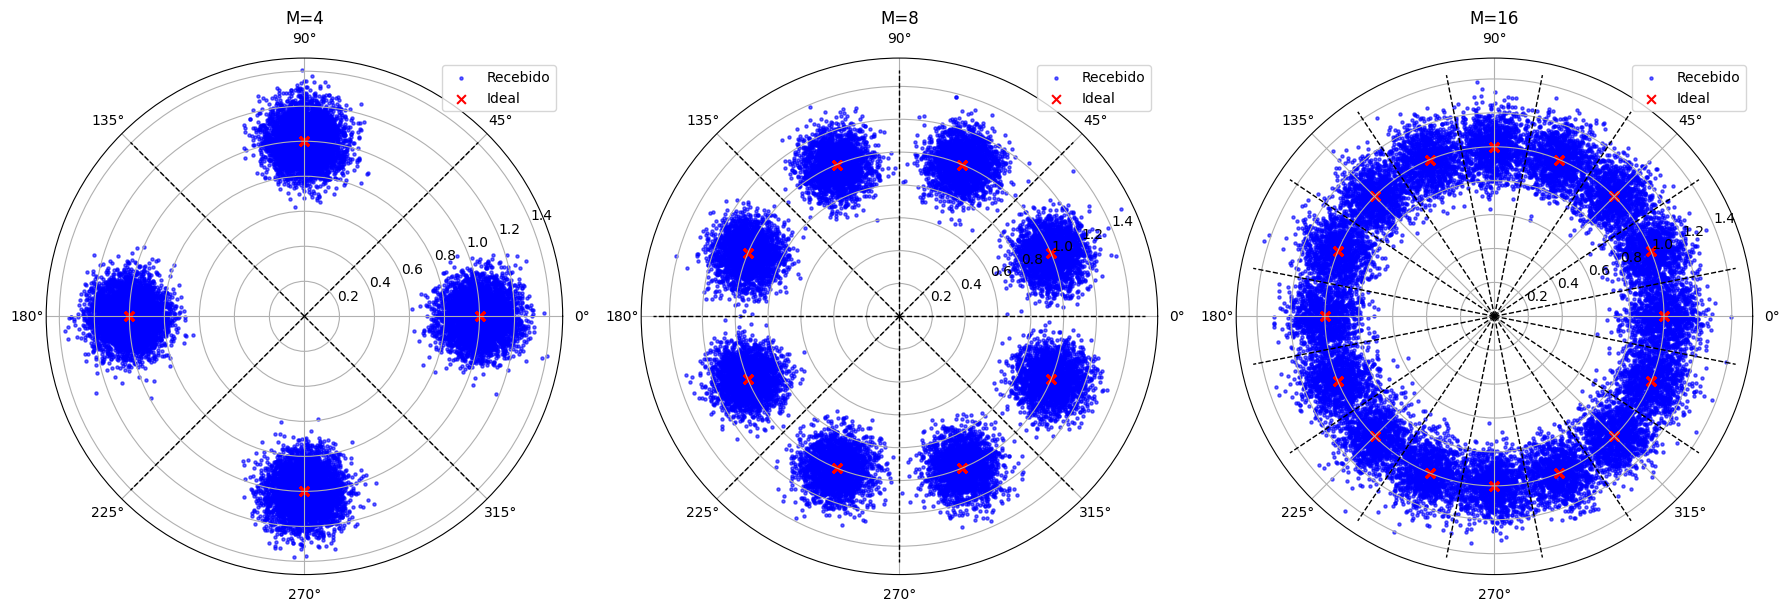

In [75]:
fig, axs = plt.subplots(1, 3, subplot_kw={'projection': 'polar'}, figsize=(18, 6))

_ = simulate_mpsk(M=4, phase_offset=0, ax=axs[0], plot_title='M=4')
_ = simulate_mpsk(M=8, phase_offset=np.pi/8, ax=axs[1], plot_title='M=8')
_ = simulate_mpsk(M=16, phase_offset=np.pi/4, ax=axs[2], plot_title='M=16')

plt.tight_layout()
plt.show()

## a. Variação do espaçamento angular e densidade de pontos

A modulação M-PSK representa os símbolos como pontos uniformemente distribuídos em um círculo no plano complexo. O espaçamento angular entre símbolos é dado por:

$$
\Delta \theta = \frac{2\pi}{M}
$$

* Para $M = 4$: $\Delta \theta = \frac{2\pi}{4} = \frac{\pi}{2}$
* Para $M = 8$: $\Delta \theta = \frac{\pi}{4}$
* Para $M = 16$: $\Delta \theta = \frac{\pi}{8}$

Conforme $M$ aumenta:

* O número de pontos na constelação aumenta.
* O espaçamento angular entre os pontos diminui, o que torna a constelação mais densa.

### b) Comparação visual entre $M = 4$ e $M = 16$

* **Vantagens de $M = 4$**:

  * Maior espaçamento angular, melhor tolerância a ruído.
  * Menor taxa de erro de bit (BER).
  * Mais robusto para canais ruidosos.

* **Desvantagens de $M = 4$**:

  * Transmite apenas 2 bits por símbolo.

* **Vantagens de $M = 16$**:

  * Transmite 4 bits por símbolo, maior taxa de transmissão de dados.

* **Desvantagens de $M = 16$**:

  * Menor distância entre símbolos, mais sensível a ruído.
  * Requer maior SNR para manter BER aceitável.

---

# 2. Offset de fase (phase\_offset)

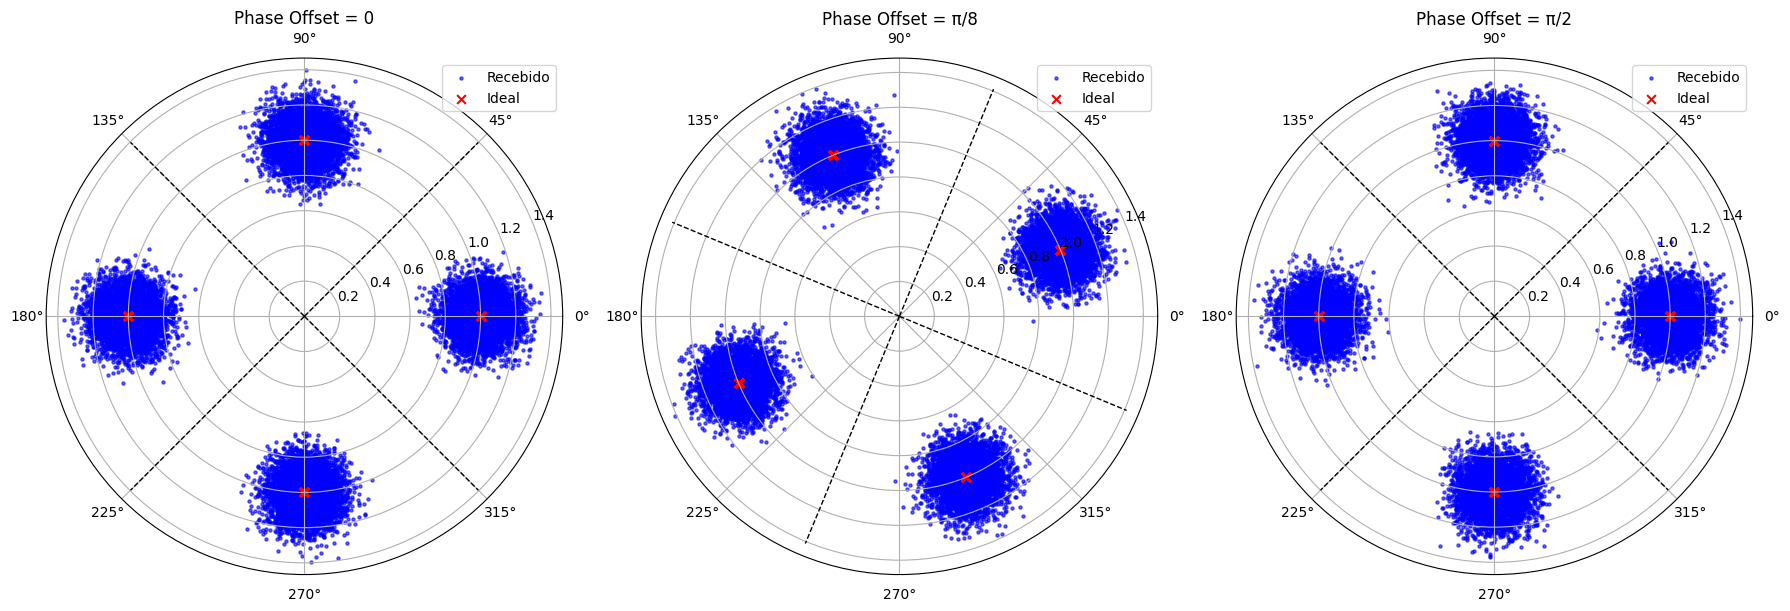

In [76]:
fig, axs = plt.subplots(1, 3, subplot_kw={'projection': 'polar'}, figsize=(18, 6))

_ = simulate_mpsk(M = 4, phase_offset=0, ax=axs[0], plot_title='Phase Offset = 0')
_ = simulate_mpsk(M = 4, phase_offset=np.pi/8, ax=axs[1], plot_title='Phase Offset = π/8')
_ = simulate_mpsk(M = 4, phase_offset=np.pi/2, ax=axs[2], plot_title='Phase Offset = π/2')

plt.tight_layout()
plt.show()

## a. Phase offset = 0

Quando $\text{phase\_offset} = 0$, os pontos da constelação iniciam a partir do eixo real positivo (0°). Isso pode alinhar melhor os símbolos para certos padrões de codificação ou hardware.

* O efeito visual é que os pontos "girados" voltam para posições com ângulos múltiplos de $\frac{2\pi}{M}$ a partir de zero.

### b. Phase offset = $\frac{\pi}{8}$ e $\frac{\pi}{2}$

* O deslocamento de fase faz a constelação girar no plano complexo.
* Na **demodulação coerente**, se o receptor conhece o offset, ele pode compensar.
* Se não conhece, o deslocamento pode causar erro de decisão, pois os símbolos são interpretados como outros (erro de fase).
* Dependendo da implementação em hardware, um offset pode facilitar a implementação de um circuito de demodulação coerente.

---

# 3. Energia por bit e $N_0$ (Eb/N0)

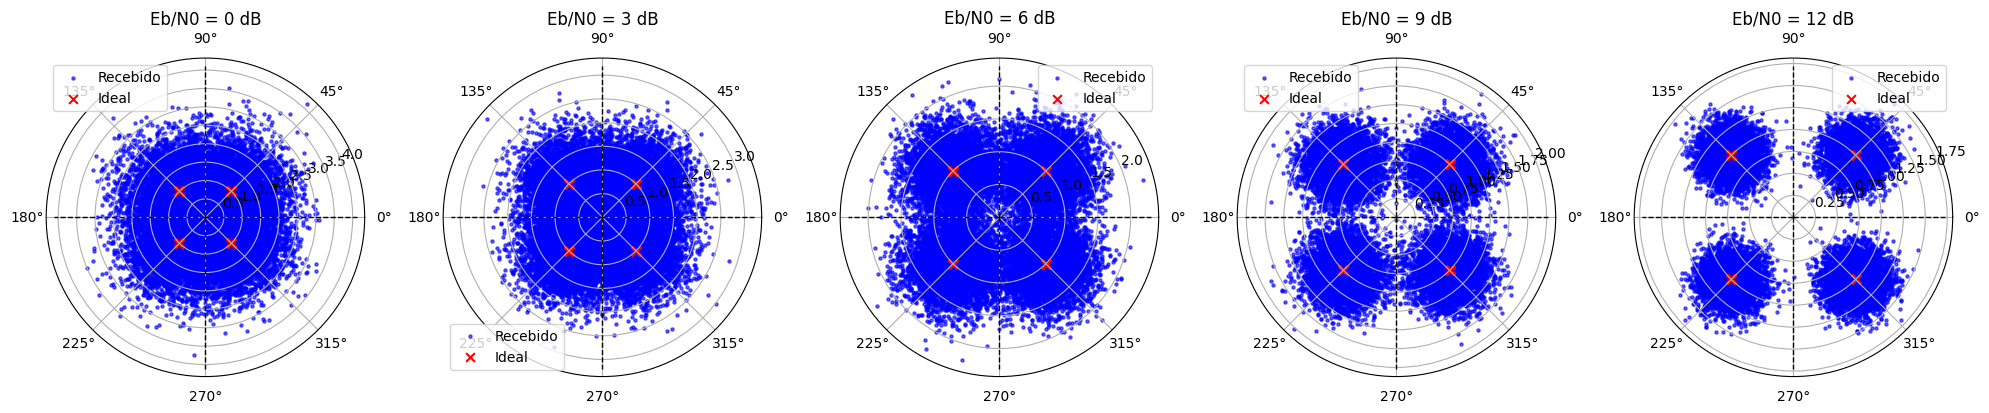

In [77]:
EbN0_dBs = [0, 3, 6, 9, 12]
fig, axs = plt.subplots(1, len(EbN0_dBs), subplot_kw={'projection': 'polar'}, figsize=(20, 5))

for i, db in enumerate(EbN0_dBs):
    simulate_mpsk(
        M=4,
        EbN0_dB=db,
        polar=True,
        ax=axs[i],
        plot_title=f'Eb/N0 = {db} dB'
    )

plt.tight_layout()
plt.show()

## a. Conversão para dB

A relação $\frac{E_b}{N_0}$ em dB é:

$$
\text{SNR}_{\text{dB}} = 10 \cdot \log_{10}\left( \frac{E_b}{N_0} \right)
$$

Exemplo: $\frac{E_b}{N_0} = \frac{45 \times 10^{-6}}{1 \times 10^{-6}} = 45 \Rightarrow 10 \cdot \log_{10}(45) \approx 16.5 \ \text{dB}$

Ao plotar a constelação para diferentes SNRs em dB, nota-se:

* Em SNR baixo, os pontos ficam mais espalhados.
* Em SNR alto, os pontos se concentram próximos ao ideal.

## b. Conjuntos para $\text{Eb/N}_0 = 0$ a $12 \ \text{dB}$

Ao gerar constelações para:

* 0 dB -> dispersão alta
* 3 dB -> melhora visível
* 6 dB -> pontos começam a se concentrar
* 9 dB -> boa definição
* 12 dB -> muito próximos dos ideais

A dispersão diminui conforme a SNR aumenta, o que reduz a BER.

---

# 4. BER Simulado

In [78]:
for M in [2, 4, 8]:
    ber = simulate_ber(M=M, num_symbols=10000000, EbN0_dB=6)
    print(f"M = {M}, BER ≈ {ber:.5e}")

M = 2, BER ≈ 2.36640e-03
M = 4, BER ≈ 3.38697e-02
M = 8, BER ≈ 1.62728e-01


## a. Demodulação coerente

Adicione demodulação coerente e calcule a BER para M = 2, 4, 8 em Eb/N0 = 6 dB

Valores obtidos:
* M = 2, BER ≈ 2.36640e-03
* M = 4, BER ≈ 3.38697e-02
* M = 8, BER ≈ 1.62728e-01

### b. Justificativa

Conforme $M$ aumenta:

* Os símbolos estão mais próximos entre si.
* Qualquer ruído pode causar erro de decisão.
* A BER aumenta devido à menor margem angular.

---

# 5. Atenuação do canal

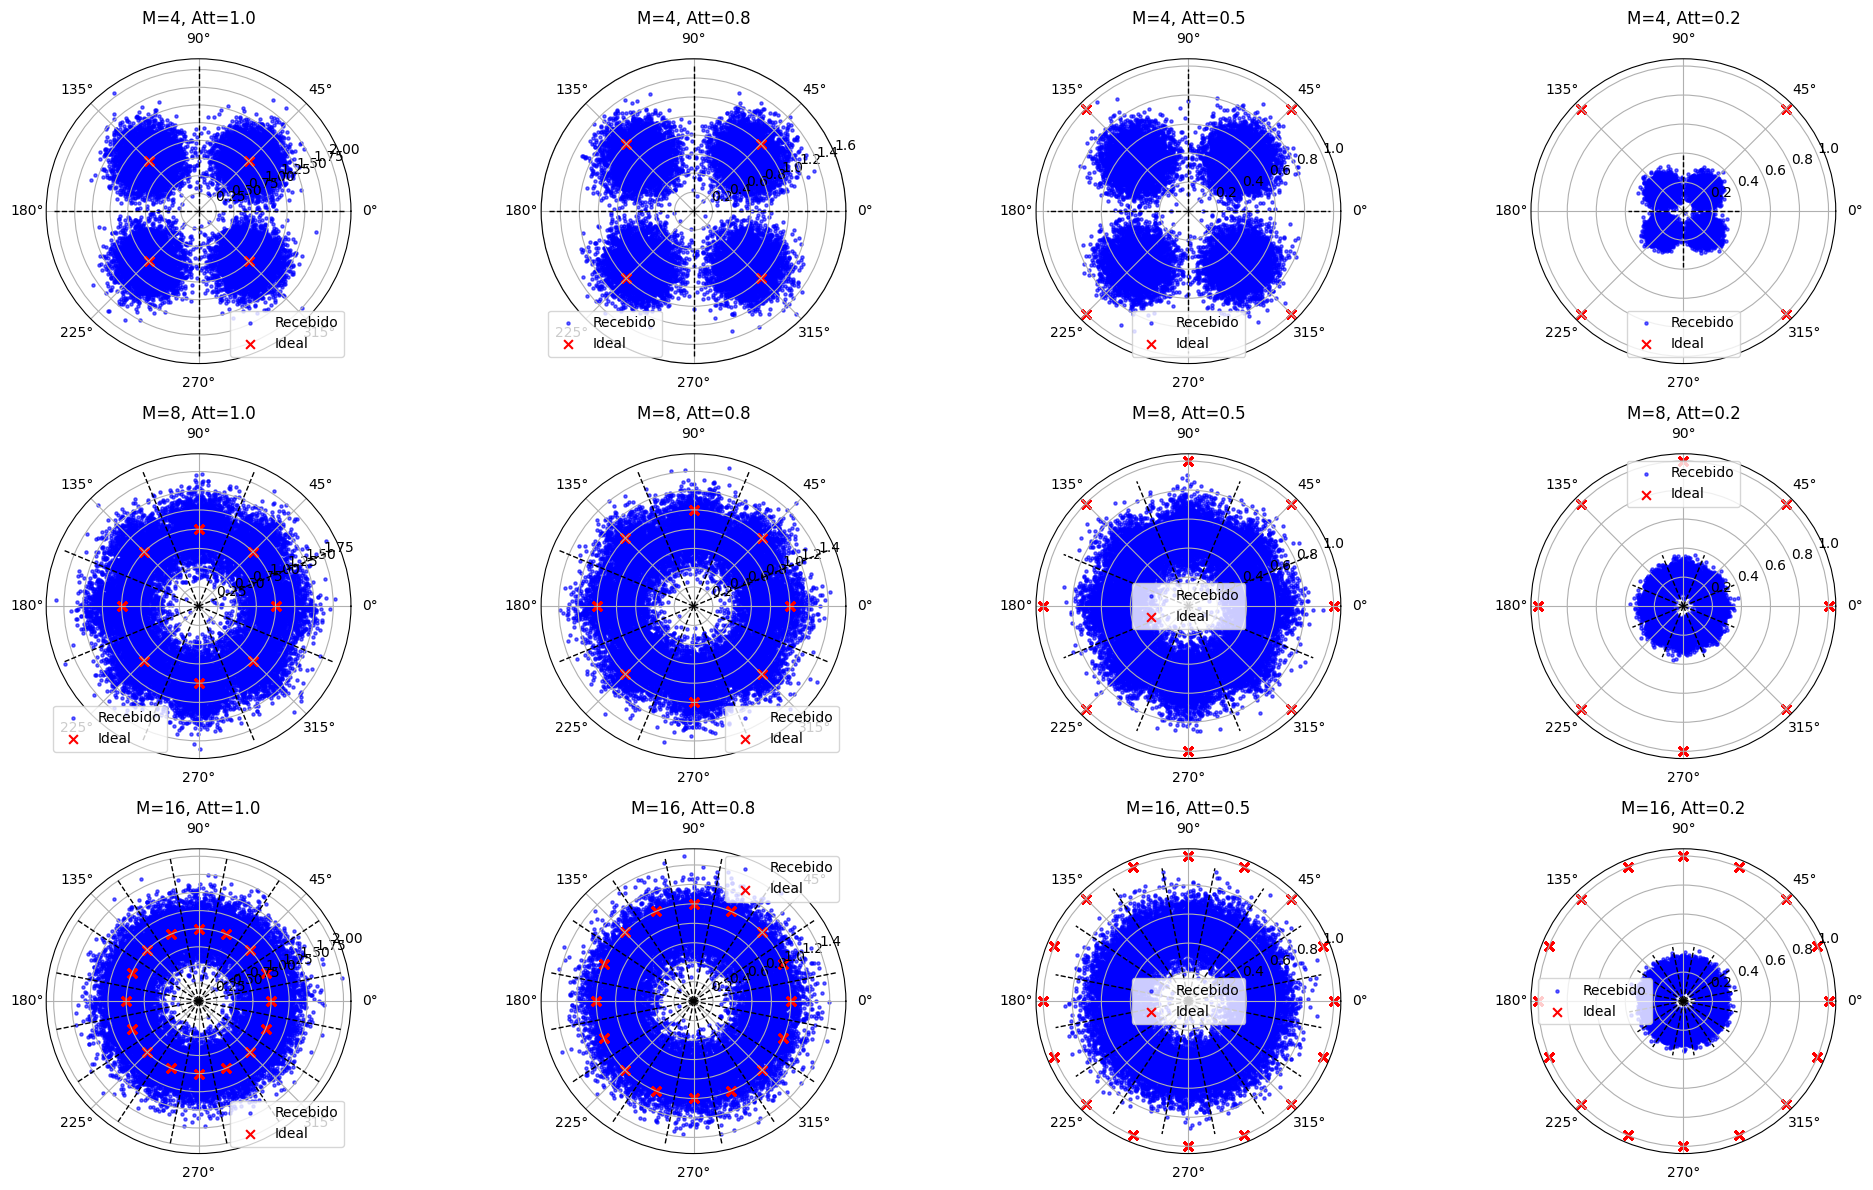

In [80]:
Ms = [4, 8, 16]
attenuations = [1.0, 0.8, 0.5, 0.2]

fig, axs = plt.subplots(len(Ms), len(attenuations), subplot_kw={'projection': 'polar'}, figsize=(20, 12))

for i, M in enumerate(Ms):
    for j, att in enumerate(attenuations):
        simulate_mpsk(
            M=M,
            EbN0_dB=10,
            attenuation=att,
            polar=True,
            ax=axs[i][j],
            plot_title=f"M={M}, Att={att}"
        )

plt.tight_layout()
plt.show()


## a. Constelação com atenuações de 0.8, 0.5 e 0.2

A atenuação reduz o **módulo** dos pontos (amplitude), mas não afeta diretamente a **fase**.

* Visualmente: constelação "encolhe".
* A dispersão relativa ao centro aumenta, tornando a decisão menos confiável.

## b. Recalculando BER

In [81]:
for M in [2, 4, 8]:
    for attenuation in [1.0, 0.8, 0.5, 0.2]:
        ber = simulate_ber(M=M, num_symbols=10000000, EbN0_dB=10, attenuation=attenuation)
        print(f"M = {M}, Att = {attenuation}, BER ≈ {ber:.5e}")

M = 2, Att = 1.0, BER ≈ 3.10000e-06
M = 2, Att = 0.8, BER ≈ 2.09830e-03
M = 2, Att = 0.5, BER ≈ 1.31658e-01
M = 2, Att = 0.2, BER ≈ 4.28895e-01
M = 4, Att = 1.0, BER ≈ 1.16740e-03
M = 4, Att = 0.8, BER ≈ 3.17061e-02
M = 4, Att = 0.5, BER ≈ 2.75873e-01
M = 4, Att = 0.2, BER ≈ 4.72231e-01
M = 8, Att = 1.0, BER ≈ 5.06604e-02
M = 8, Att = 0.8, BER ≈ 1.58921e-01
M = 8, Att = 0.5, BER ≈ 3.70359e-01
M = 8, Att = 0.2, BER ≈ 4.83110e-01


Com $\text{Eb/N}_0 = 10 \ \text{dB}$:

* Atenuação 0.8 -> BER maior
* Atenuação 0.5 -> BER cresce visivelmente
* Atenuação 0.2 -> BER muito alta

Isso ocorre porque a atenuação reduz o SNR real, já que o sinal chega com menos potência ao receptor.

---

# 6. Distorção de fase

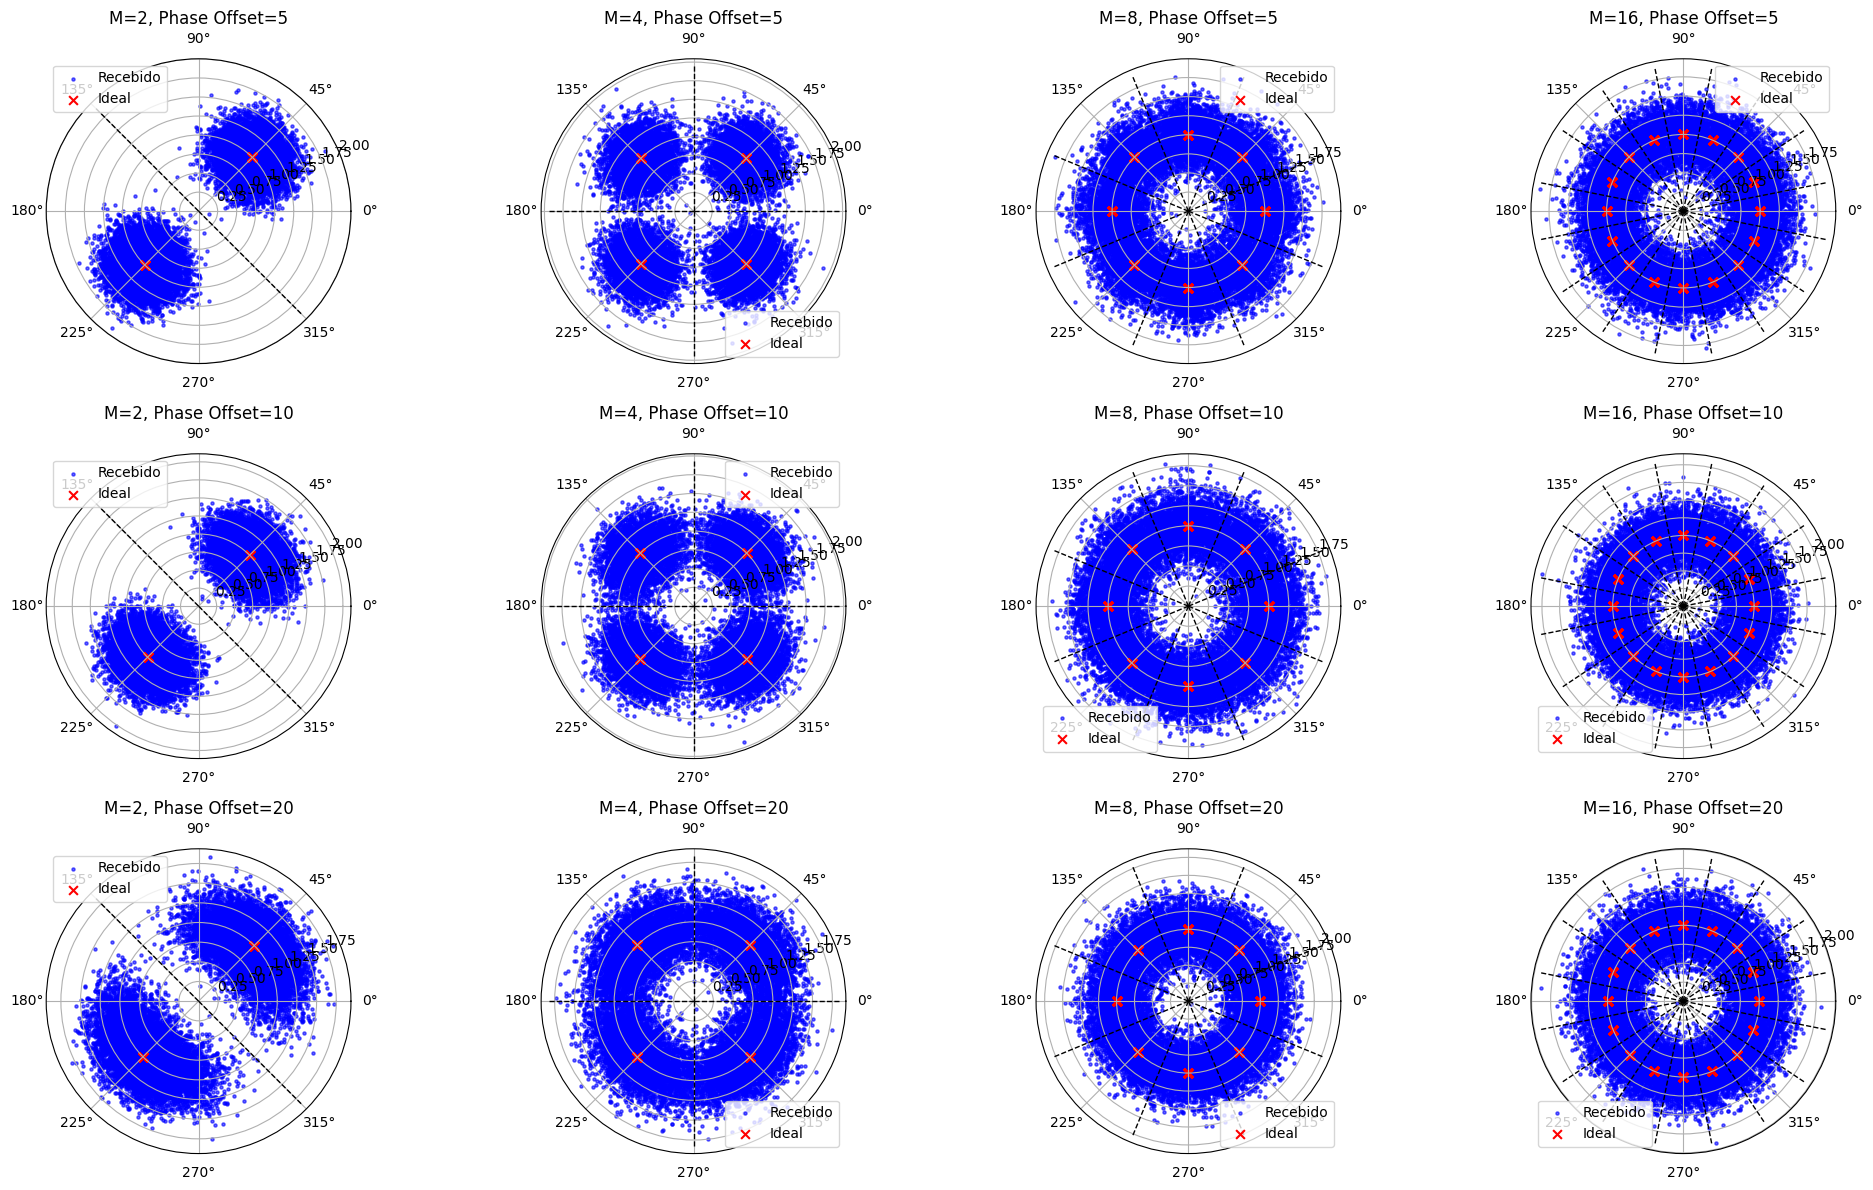

In [82]:
Ms = [2, 4, 8, 16]
phases = [5, 10, 20]

fig, axs = plt.subplots(len(phases), len(Ms), subplot_kw={'projection': 'polar'}, figsize=(20, 12))

for i, p in enumerate(phases):
    for j, M in enumerate(Ms):
        simulate_mpsk(
            M=M,
            EbN0_dB=10,
            phase_distortion_deg=p,
            polar=True,
            ax=axs[i][j],
            plot_title=f"M={M}, Phase Offset={p}"
        )

plt.tight_layout()
plt.show()


## a. Com desvio padrão de 5°, 10° e 20°

* $M = 2$: Menor afetado
* $M = 8$ ou $M = 16$: Muito sensível

Modulações com alta ordem são mais vulneráveis porque o erro angular afeta mais a decisão.

## b. Técnicas de mitigação

1. **PLL (Phase Locked Loop)** – Rastreia e corrige desvios de fase, (Eg. Costas Loop)
2. **Pilotos de Fase** – Símbolos conhecidos inseridos no sinal para corrigir a fase estimada.

---

# 7. Potência média do sinal

In [83]:
for M in [2, 4, 8]:
    result = simulate_mpsk(M=M, show=False, ax=None, EbN0_dB=10)
    print(f"M = {M}, Potência média ideal ≈ {result['signal_power']:.6f}")

M = 2, Potência média ideal ≈ 1.000000
M = 4, Potência média ideal ≈ 1.000000
M = 8, Potência média ideal ≈ 1.000000


Para PSK, todos os pontos têm o mesmo módulo -> potência constante:

$$
P = \text{mean}(|s[n]|^2) \approx 1
$$

No script:

Para $M = 2, 4, 8$: o valor será próximo de 1, pois é PSK de módulo unitário.

---

# 8. Transmissão banda-passante (Fc = 50 kHz)

## a. Qual o requisito mínimo de taxa de amostragem (Fs) para evitar aliasing?

De acordo com o Teorema de Nyquist:

$$
F_s > 2F_c
$$

Para $F_c = 50 \text{ kHz}$, o mínimo é:

$$
F_s > 100 \text{ kHz}
$$

Usar $F_s = 200 \text{ kHz}$ é adequado para evitar aliasing e permitir observar o espectro claramente.


## b. Analise o duplo espelhamento do espectro típico de modulação analógica


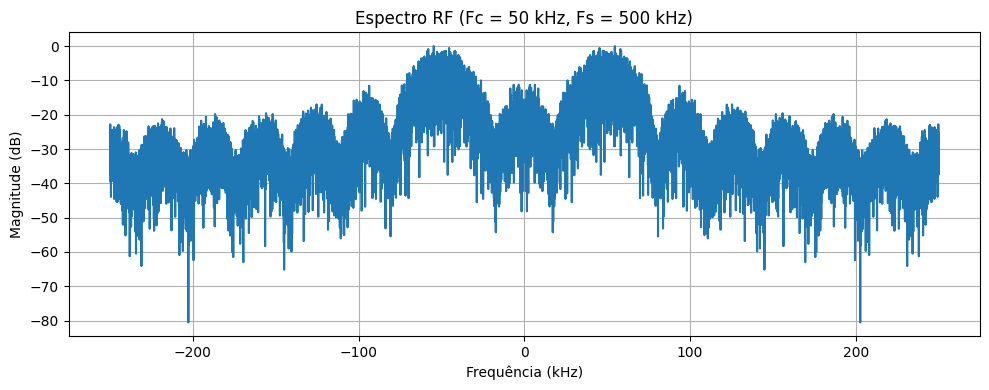

In [84]:
_ = simulate_mpsk(
    M=2,
    num_symbols=10000,
    EbN0_dB=10,
    Fs=500e3, # One order of magnitude
    Fc=50e3,
    plot_rf_spectrum=True,
    show=False
)

### Análise do Espectro RF (Fc = 50 kHz, Fs = 500 kHz)

O espectro mostra a modulação de um sinal digital BPSK deslocado para banda passante com uma portadora em **50 kHz**, utilizando uma taxa de amostragem de **500 kHz**.

* É possível observar **duas bandas laterais simétricas** em torno de ±50 kHz, evidência clara da **modulação em frequência real**, já que foi tomada a parte real do sinal modulado.
* A **largura do espectro** ao redor de cada pico reflete a **largura de banda do sinal baseband**, que depende da taxa de símbolos e do tipo de pulso usado.
* Como a frequência de amostragem $F_s = 500\,\text{kHz}$ é maior que o dobro da frequência da portadora $F_c = 50\,\text{kHz}$, o **teorema de Nyquist** é respeitado, e **não há aliasing** visível.